In [6]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import scienceplots
from cmap import Colormap

In [7]:
cmap = Colormap("seaborn:mako").to_mpl()

In [8]:
N_COLLOCATION_POINTS = 8
N_DATA_POINTS = 5

DATA_LOSS_WEIGHT = 20.0

LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 10000

XMIN = 0
XMAX = 2 * jnp.pi
YMIN = 0
YMAX = 2 * jnp.pi
TMIN = 0
TMAX = 50

NU = 1e-3

In [9]:
def velocity_field(x, y, t):
    Ft = jnp.exp(-2 * NU * t)
    u = jnp.sin(x) * jnp.cos(y) * Ft
    v = -jnp.cos(x) * jnp.sin(y) * Ft
    return u, v

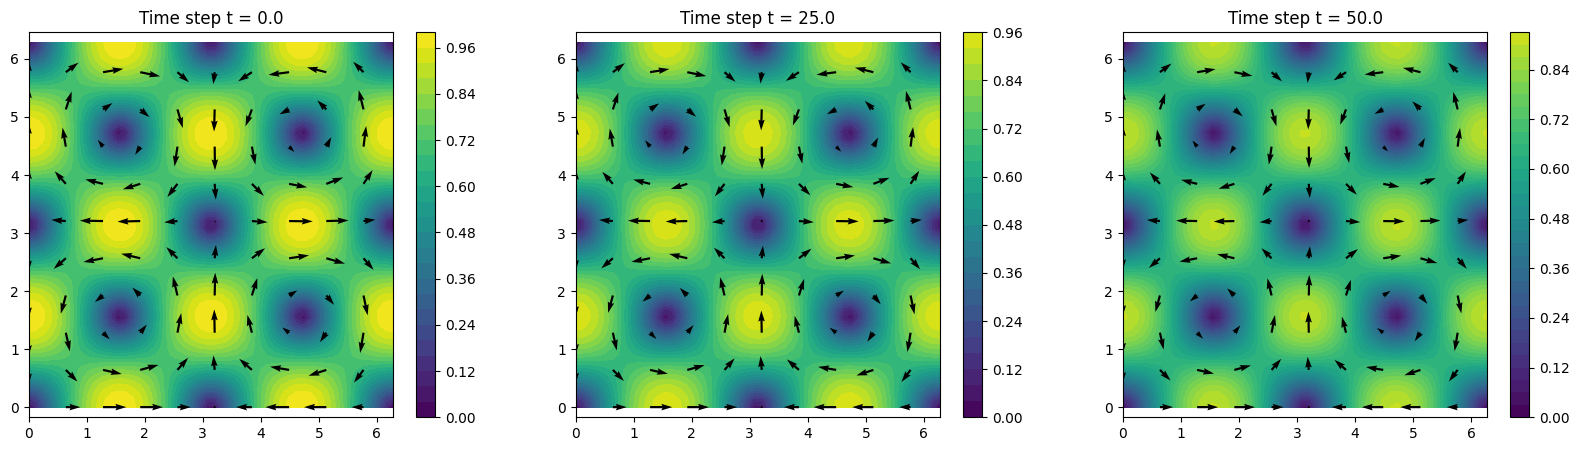

In [10]:
x_mesh = jnp.linspace(0, 2 * np.pi)
y_mesh = jnp.linspace(0, 2 * np.pi)
t_mesh = jnp.array([0, TMAX / 2, TMAX])

X, Y = jnp.meshgrid(x_mesh, y_mesh)


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, t in enumerate(t_mesh):
    U, V = velocity_field(X, Y, t)
    magnitude = jnp.sqrt(U**2 + V**2)
    contour = axes[i].contourf(X, Y, magnitude, 30, cmap='viridis', vmax=1)
    fig.colorbar(contour, ax=axes[i])
    axes[i].set_title(f"Time step t = {t}")
    axes[i].axis('equal')
    axes[i].quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5], color='k', scale=15)

In [11]:
def pressure_field(x, y, t):
    Ft = jnp.exp(-2 * NU * t)
    return 1 / 4 * (jnp.cos(2 * x) + jnp.sin(2 * y)) * Ft**2

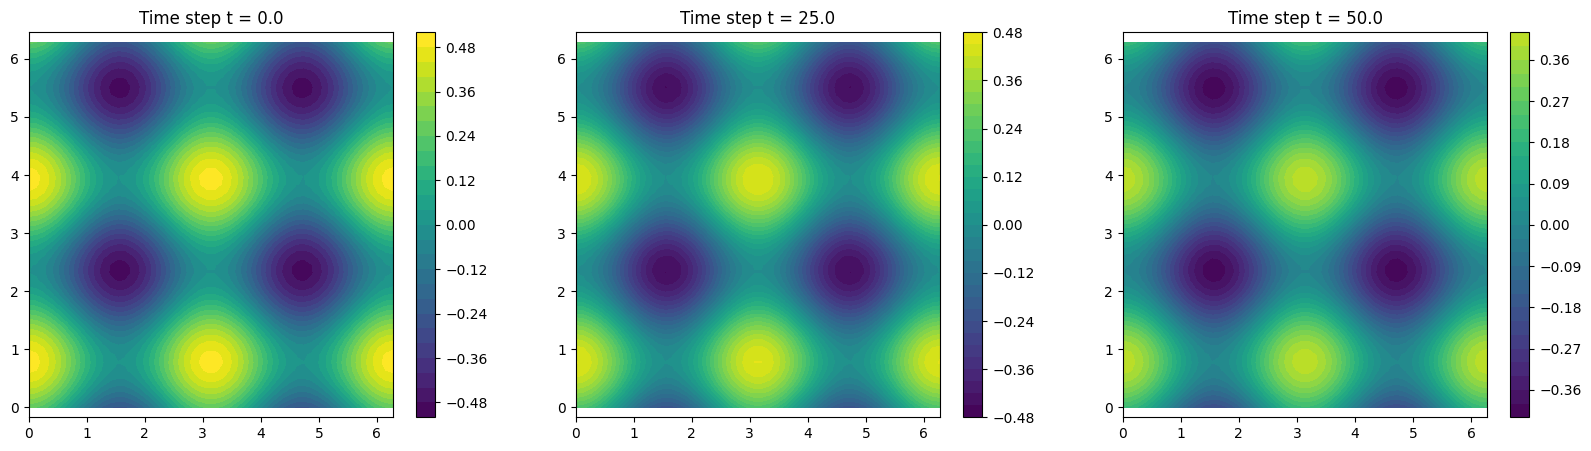

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, t in enumerate(t_mesh):
    P = pressure_field(X, Y, t)
    contour = axes[i].contourf(X, Y, P, 30, cmap='viridis', vmax=0.5)
    fig.colorbar(contour, ax=axes[i])
    axes[i].set_title(f"Time step t = {t}")
    axes[i].axis('equal')

In [13]:
key = jr.PRNGKey(42)

In [14]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size=3,
    out_size=3,
    width_size=20,
    depth=4,
    activation=jax.nn.sigmoid,
    key=key,
)

In [15]:
@eqx.filter_jit
def pde_residuum(network, inputs):
    x = inputs[0]
    y = inputs[1]
    t = inputs[2]

    uvp = network(inputs)
    u = uvp[0]
    v = uvp[1]
    p = uvp[2]

    grad_uvp = jax.jacfwd(lambda inputs: network(inputs))(inputs)  # Shape: (num_points, 3, 3)
    du_dx, du_dy, du_dt = grad_uvp[0, 0], grad_uvp[0, 1], grad_uvp[0, 2]
    dv_dx, dv_dy, dv_dt = grad_uvp[1, 0], grad_uvp[1, 1], grad_uvp[1, 2]
    dp_dx, dp_dy, dp_dt = grad_uvp[2, 0], grad_uvp[2, 1], grad_uvp[2, 2]

    # Compute second derivatives using jacfwd (forward-mode)
    grad_du_dx = jax.jacfwd(lambda x: du_dx)(x)  # d2u_dx2
    grad_dv_dx = jax.jacfwd(lambda x: dv_dx)(x)  # d2v_dx2
    grad_du_dy = jax.jacfwd(lambda y: du_dy)(y)  # d2u_dy2
    grad_dv_dy = jax.jacfwd(lambda y: dv_dy)(y)  # d2v_dy2
    
    # Continuity and momentum equations
    continuity_eqn = du_dx + dv_dy
    mom_u_eqn = du_dt + u * du_dx + v * du_dy + dp_dx - NU * (grad_du_dx + grad_du_dy)
    mom_v_eqn = dv_dt + u * dv_dx + v * dv_dy + dp_dy - NU * (grad_dv_dx + grad_dv_dy)
    
    residual = jnp.array([continuity_eqn, mom_u_eqn, mom_v_eqn])  # Shape: (num_points, 3)
    return residual

In [16]:
@eqx.filter_jit
def data_residuum(network, inputs):
    x = inputs[0]
    y = inputs[1]
    t = inputs[2]
    
    u, v = velocity_field(x, y, t)
    p = pressure_field(x, y, t)
    
    return network(inputs) - jnp.stack([u, v, p], axis=-1)

In [17]:
key, coll_sampling_key = jr.split(key)
ts = jnp.linspace(0, TMAX, 20)
xs = jnp.linspace(0, XMAX, N_DATA_POINTS)
ys = jnp.linspace(0, YMAX, N_DATA_POINTS)
X, Y, T = jnp.meshgrid(xs, ys, ts, indexing="ij")
data_points = jnp.stack([X.ravel(), Y.ravel(), T.ravel()]).T

ts = jnp.linspace(0, TMAX, N_COLLOCATION_POINTS)
xs = jnp.linspace(0, XMAX, N_COLLOCATION_POINTS)
ys = jnp.linspace(0, YMAX, N_COLLOCATION_POINTS)
X, Y, T = jnp.meshgrid(xs, ys, ts, indexing="ij")
coll_points = jnp.stack([X.ravel(), Y.ravel(), T.ravel()]).T

@eqx.filter_jit
def loss_fn(network):
    pde_res_coll = jax.vmap(pde_residuum, in_axes=(None, 0))(network, coll_points)
    pde_loss = jnp.mean(jnp.square(pde_res_coll))
    
    data_res = jax.vmap(data_residuum, in_axes=(None, 0))(network, data_points)
    data_loss = jnp.mean(jnp.square(data_res))
    
    total_loss = 0.5 * (pde_loss + DATA_LOSS_WEIGHT * data_loss)
    
    return total_loss

In [18]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))
loss_history = []

In [24]:
@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 0.038973040878772736
Epoch: 100, loss: 0.03859178349375725
Epoch: 200, loss: 0.03829794004559517
Epoch: 300, loss: 0.03781106323003769
Epoch: 400, loss: 0.03741654381155968
Epoch: 500, loss: 0.037057533860206604
Epoch: 600, loss: 0.03659607470035553
Epoch: 700, loss: 0.036178432404994965
Epoch: 800, loss: 0.03582736849784851
Epoch: 900, loss: 0.03527653589844704
Epoch: 1000, loss: 0.034808237105607986
Epoch: 1100, loss: 0.034329891204833984
Epoch: 1200, loss: 0.03465709462761879
Epoch: 1300, loss: 0.0335141122341156
Epoch: 1400, loss: 0.032843660563230515
Epoch: 1500, loss: 0.03229169175028801
Epoch: 1600, loss: 0.03177540749311447
Epoch: 1700, loss: 0.03125559538602829
Epoch: 1800, loss: 0.0307433120906353
Epoch: 1900, loss: 0.030243076384067535
Epoch: 2000, loss: 0.03073211945593357
Epoch: 2100, loss: 0.029510505497455597
Epoch: 2200, loss: 0.028912434354424477
Epoch: 2300, loss: 0.028583336621522903
Epoch: 2400, loss: 0.027990829199552536
Epoch: 2500, loss: 0.0276061

(50, 50)
(50, 50)
(50, 50)


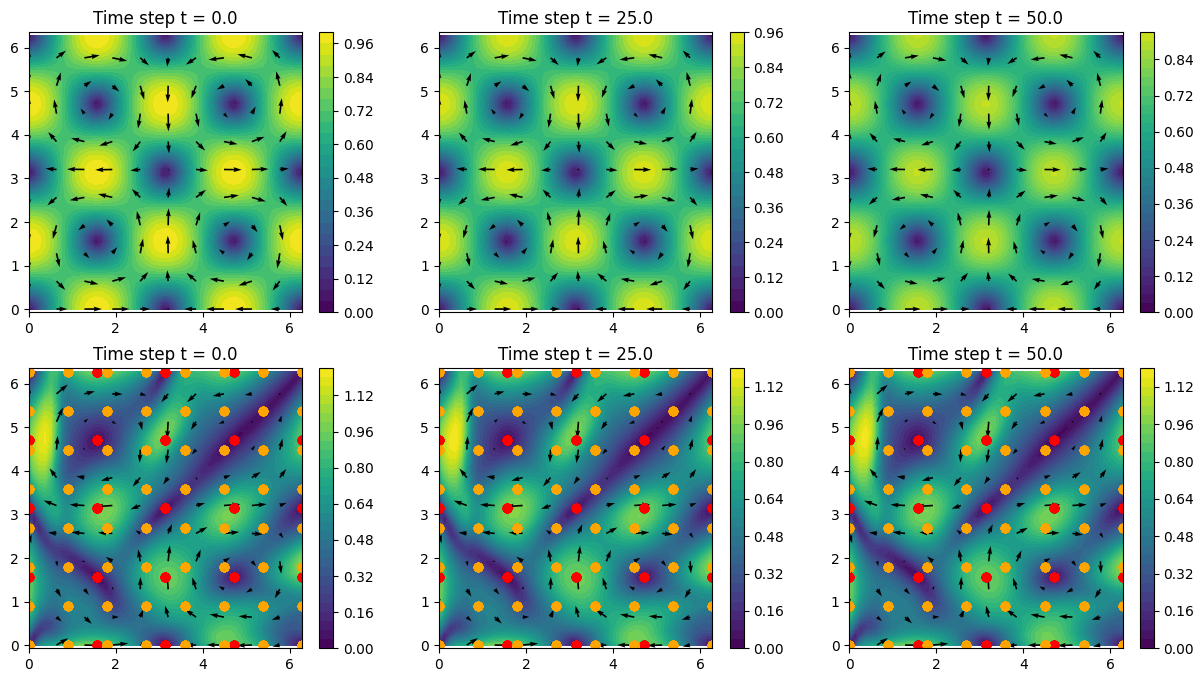

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x_mesh = jnp.linspace(0, 2 * np.pi)
y_mesh = jnp.linspace(0, 2 * np.pi)
t_mesh = jnp.array([0, TMAX / 2, TMAX])

X, Y = jnp.meshgrid(x_mesh, y_mesh)

for i, t in enumerate(t_mesh):
    U, V = velocity_field(X, Y, t)
    magnitude = jnp.sqrt(U**2 + V**2)
    contour = axes[0, i].contourf(X, Y, magnitude, 30, cmap='viridis', vmax=1)
    fig.colorbar(contour, ax=axes[0, i])
    axes[0, i].set_title(f"Time step t = {t}")
    axes[0, i].axis('equal')
    axes[0, i].quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5], color='k', scale=15)


x_mesh = jnp.linspace(0, 2 * np.pi)
y_mesh = jnp.linspace(0, 2 * np.pi)
t_mesh = jnp.array([0, TMAX / 2, TMAX])
X, Y = jnp.meshgrid(x_mesh, y_mesh)

# fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, t in enumerate(t_mesh):
    inputs = jnp.stack([X.flatten(), Y.flatten(), jnp.full_like(X.flatten(), t)], axis=-1)
    output = jax.vmap(pinn)(inputs)
    U, V, P = jnp.split(output, 3, axis=-1)
    U = U.reshape(X.shape)
    V = V.reshape(X.shape)
    P = P.reshape(X.shape)

    magnitude = jnp.sqrt(U**2 + V**2)
    print(magnitude.shape)
    
    contour = axes[1, i].contourf(X, Y, magnitude, 30, cmap='viridis')
    fig.colorbar(contour, ax=axes[1, i])
    axes[1, i].set_title(f"Time step t = {t}")
    axes[1, i].axis('equal')
    axes[1, i].quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5], color='k', scale=15)

# print()

    axes[1, i].scatter(data_points[:, 0], data_points[:, 1], c="red")
    axes[1, i].scatter(coll_points[:, 0], coll_points[:, 1], c="orange")

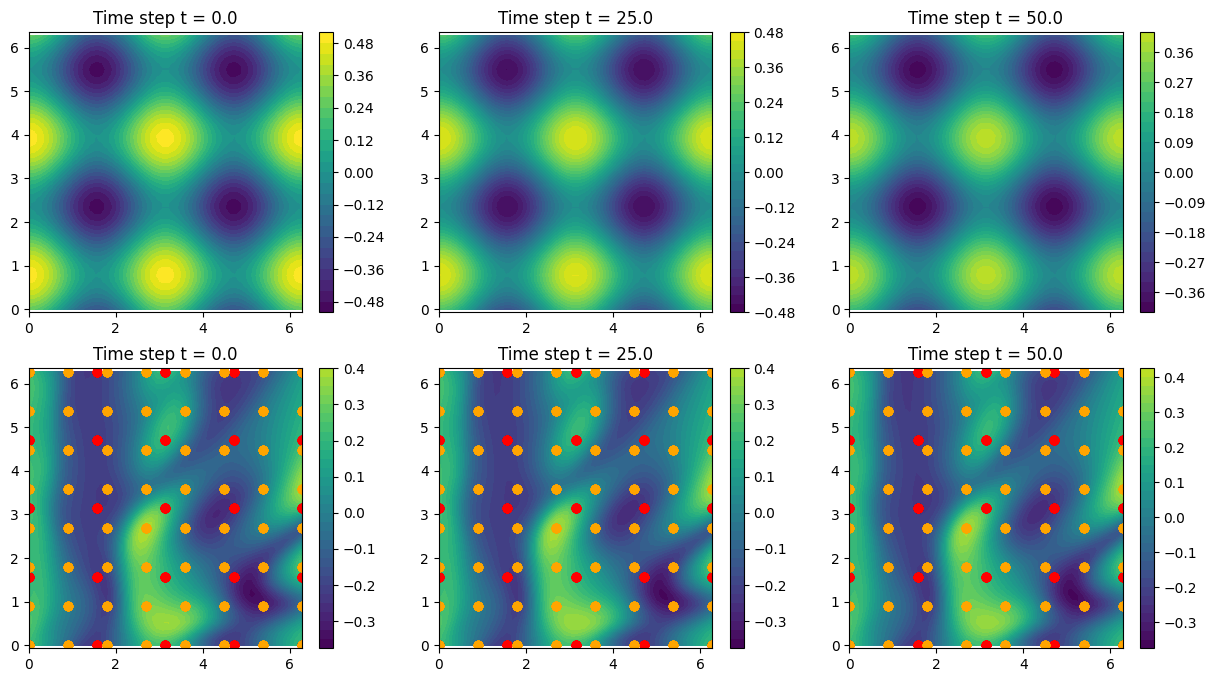

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, t in enumerate(t_mesh):
    P = pressure_field(X, Y, t)
    contour = axes[0, i].contourf(X, Y, P, 30, cmap='viridis', vmax=0.5)
    fig.colorbar(contour, ax=axes[0, i])
    axes[0, i].set_title(f"Time step t = {t}")
    axes[0, i].axis('equal')

x_mesh = jnp.linspace(0, 2 * np.pi)
y_mesh = jnp.linspace(0, 2 * np.pi)
t_mesh = jnp.array([0, TMAX / 2, TMAX])
X, Y = jnp.meshgrid(x_mesh, y_mesh)

# fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, t in enumerate(t_mesh):
    inputs = jnp.stack([X.flatten(), Y.flatten(), jnp.full_like(X.flatten(), t)], axis=-1)
    output = jax.vmap(pinn)(inputs)
    U, V, P = jnp.split(output, 3, axis=-1)
    U = U.reshape(X.shape)
    V = V.reshape(X.shape)
    P = P.reshape(X.shape)
    
    contour = axes[1, i].contourf(X, Y, P, 30, cmap='viridis', vmax=0.5)
    fig.colorbar(contour, ax=axes[1, i])
    axes[1, i].set_title(f"Time step t = {t}")
    axes[1, i].axis('equal')

    axes[1, i].scatter(data_points[:, 0], data_points[:, 1], c="red")
    axes[1, i].scatter(coll_points[:, 0], coll_points[:, 1], c="orange")

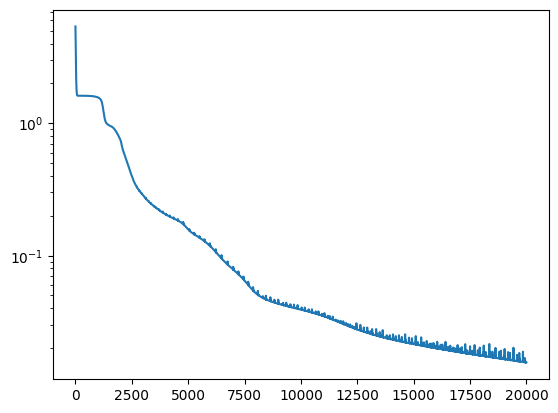

In [25]:
plt.plot(loss_history)
plt.yscale("log")